# Imports

# 이걸.. 안 해놔?
import sys
sys.path.append('..')

In [1]:
import numpy as np
import librosa
from util import play_audio, load_audio, get_features, get_mfcc, get_lmfe, get_chroma, plot_chroma, plot_mfcc, plot_lmfe
from tqdm.notebook import trange, tqdm
import os
import tensorflow as tf

import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="white", palette="muted")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

import torch
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.neighbors import KernelDensity
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2024-05-28 16:52:30.178051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 16:52:30.180500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-28 16:52:30.180508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd

# Load data

In [3]:
def load_data(machine, base_dir='data/', id=[0, 2]):
    '''
    Find the audio directory
    Inputs:
    machine: Name of the machine (valve/slider/fan/pump)
    id: ID of the machine (0,2,4,6)
    base_dir = Base directory of the dataset

    Outputs:
    dirs: List of data addresses
    labels: List of labels (1 -> normal, 0 -> abnormal)
    '''

    dirs = []
    labels = []

    for machine_id in id:
        normal_dir = base_dir + machine + '/id_' + str(format(machine_id, '02d')) + '/normal'
        abnormal_dir = base_dir + machine + '/id_' + str(format(machine_id, '02d')) + '/abnormal'

        normal_files = os.listdir(normal_dir)
        for filename in normal_files:
            dir_address = os.path.join(normal_dir, filename)
            dirs.append(dir_address)
            labels.append(1)

        abnormal_files = os.listdir(abnormal_dir)
        for filename in abnormal_files:
            dir_address = os.path.join(abnormal_dir, filename)
            dirs.append(dir_address)
            labels.append(-1)

    return dirs, labels

## Load Fan dataset

In [4]:
#load data
machine = 'fan'
ids = [0, 2, 4]
dirs, label = load_data(machine, base_dir = 'data/', id = ids)

In [5]:
# make df
df_fan = pd.DataFrame({'filename': dirs, 'label': label})
df_fan.head()
df_fan['type'] = 'fan'

In [6]:
df_fan['model'] = df_fan['filename'].apply(lambda x: x.split('/')[2][4])
df_fan.label.value_counts()

 1    3060
-1    1114
Name: label, dtype: int64

## Load valve dataset

In [7]:
#load data
machine = 'valve'
ids = [0, 2, 4]
dirs, label = load_data(machine, base_dir = 'data/', id = ids)

In [8]:
# make df
df_valve = pd.DataFrame({'filename': dirs, 'label': label})
df_valve.head()
df_valve['type'] = 'valve'

In [9]:
df_valve['model'] = df_valve['filename'].apply(lambda x: x.split('/')[2][4])
df_valve.label.value_counts()

 1    2699
-1     359
Name: label, dtype: int64

# Extract Features + plot

In [10]:
df = pd.concat([df_fan, df_valve], axis=0) # 스킵

In [11]:
# df.to_pickle('working/df.pkl') # 이 놈은 첫 실행만 켜주는 듯
df = pd.read_pickle('working/df.pkl')

In [12]:
df.columns

Index(['filename', 'label', 'type', 'model'], dtype='object')

In [13]:
norm_fan_ex = df[(df['label'] == 1) & (df['type'] == 'fan')].sample(3)
ab_fan_ex = df[(df['label'] == -1) & (df['type'] == 'fan')].sample(3)

norm_valve_ex = df[(df['label'] == 1) & (df['type'] == 'valve')].sample(3)
ab_valve_ex = df[(df['label'] == -1) & (df['type'] == 'valve')].sample(3)

sample = pd.concat([norm_fan_ex, ab_fan_ex, norm_valve_ex, ab_valve_ex])
sample_wav = [load_audio(file)[0] for file in sample['filename']]
sample_sr = [load_audio(file)[1] for file in sample['filename']]
lab = ['Normal Fan', 'Normal Fan', 'Normal Fan', 'Abnormal Fan', 'Abnormal Fan', 'Abnormal Fan',
       'Normal valve', 'Normal valve', 'Normal valve', 'Abnormal valve', 'Abnormal valve', 'Abnormal valve']

# Play abnormal and normal smaples

Normal Fan


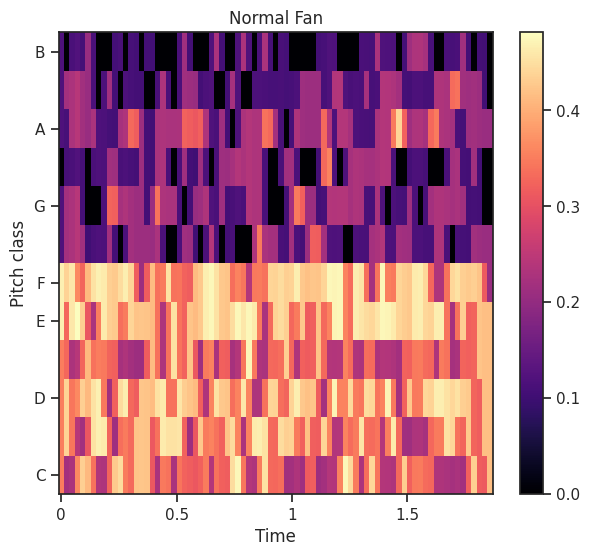

Abnormal Fan


KeyboardInterrupt: 

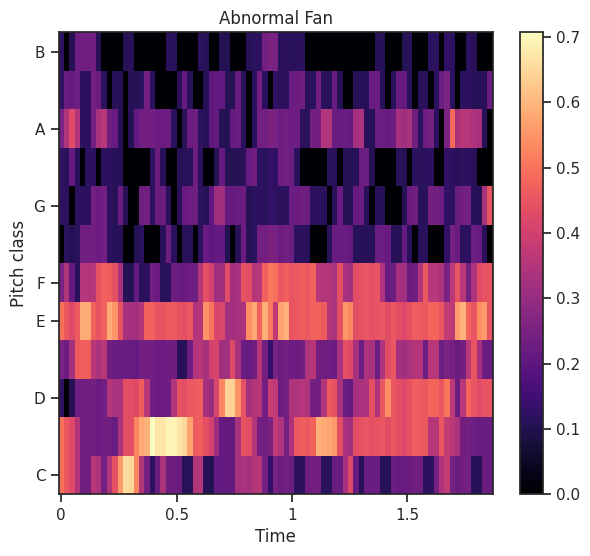

In [14]:
## Fan normal
print(lab[0])
play_audio(sample_wav[0], sample_sr[0])
plot_chroma(sample_wav[0], [lab[0]], typ='fan_1')

## Fan abnormal
print(lab[3])
play_audio(sample_wav[3], sample_sr[3])
plot_chroma(sample_wav[3], [lab[3]], typ='fan_abnorm1')

Normal valve


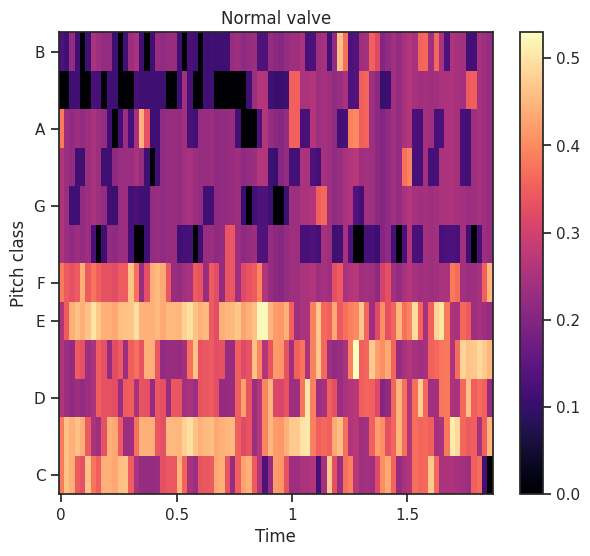

Abnormal valve


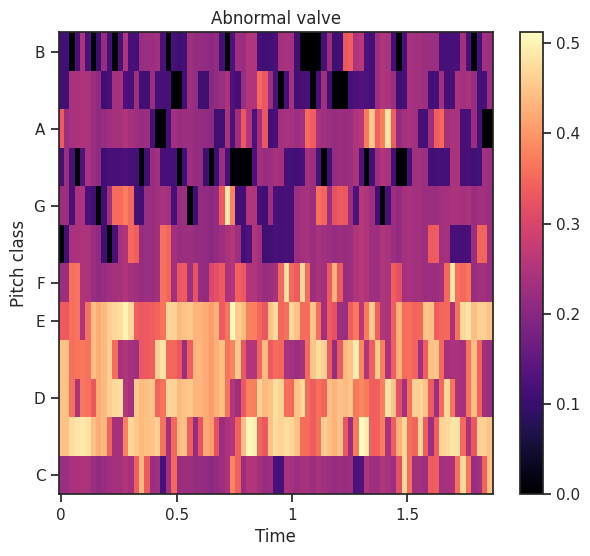

In [ ]:
# valve normal
print(lab[6])
play_audio(sample_wav[6], sample_sr[6])
plot_chroma(sample_wav[6], [lab[6]], typ='valve_1')
# valve abnormal
print(lab[9])
play_audio(sample_wav[9], sample_sr[9])
plot_chroma(sample_wav[9], [lab[9]], typ='valve_abnorm1')

## Side by side plots of 3 samples /label

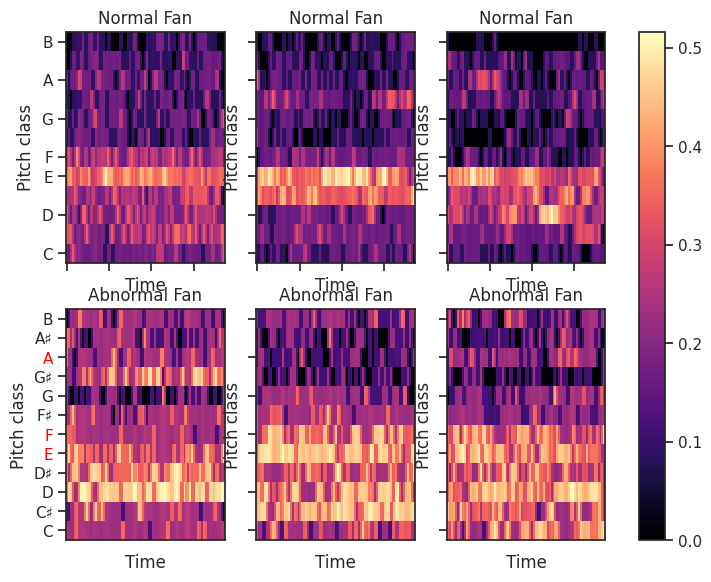

In [ ]:
plot_chroma(sample_wav[:6], lab[:6], typ='fan', sig_pitch=[4,5,9])

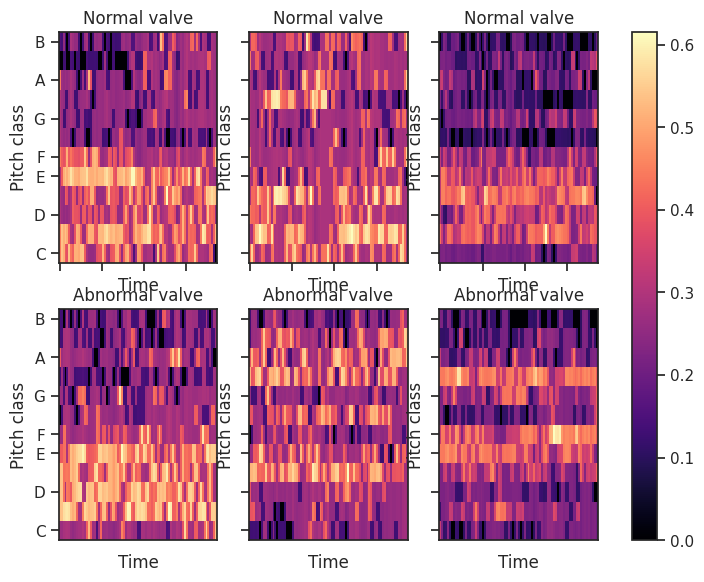

In [ ]:
plot_chroma(sample_wav[6:], lab[6:], typ='valve')

***
***Seems promsing!***
Lets try building a anomaly detection AE model using the Chromagram. 
For comparison a we'll use a baseline model with the maelspectogram as input as this is a commonly used method of Audio anomoly detection.

# Set up for AE

## Helper functions

In [ ]:
def file_to_vector_mel(file_name,
                         n_mels=64,
                         frames=2,
                         n_fft=2048,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    y, sr = load_audio(file_name)
    y = y[0].numpy()
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1


    # # 06 generate feature vectors by concatenating multi_frames
    # vectorarray = np.zeros((vectorarray_size, dims), float)
    # for t in range(frames):
    #     vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return log_mel_spectrogram

In [ ]:
def file_to_vector_chroma(file_name,
                         n_chroma=12,
                         d=5,
                         win_len_smooth=41,
                         frames=1, #not in use
                         hop_length=512):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_chroma * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    y, sr = load_audio(file_name)
    y = y[0].numpy()
    cens_gram = librosa.feature.chroma_cens(y=y,
                                            sr=sr,
                                            n_chroma=n_chroma,
                                            win_len_smooth=win_len_smooth,
                                            bins_per_octave=n_chroma*3)

    return cens_gram[:, ::d]

In [ ]:
def list_to_vector_array(vector_arrays):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.

    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.

    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    len_list= len(vector_arrays)

    # 02 loop of file_to_vectorarray
    for idx in tqdm(range(len(vector_arrays))):
        vector_array= vector_arrays[idx]

        if idx == 0:
            dataset = np.zeros((len_list, vector_array.shape[0], vector_array.shape[1]), float)

        dataset[idx, :, :] = vector_array

    return dataset

In [ ]:
class AnomalyDetector(Model):
    def __init__(self, shape):
        super(AnomalyDetector, self).__init__()
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(64, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(tf.math.reduce_prod(shape), activation=None),
          layers.Reshape(shape)])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def get_matrices(df, feat='mel'):
    train = list_to_vector_array(df[(df["train"] == 1)][feat].tolist())
    val = list_to_vector_array(df[(df["test"] == 1)][feat].tolist())
    val_norm = list_to_vector_array(df[(df["test"] == 1) & (df["label"] == 1)][feat].tolist())
    val_abnorm = list_to_vector_array(df[(df["test"] == 1) & (df["label"] != 1)][feat].tolist())
    
    min_val = tf.reduce_min(train)
    max_val = tf.reduce_max(train)
    
    train = (train - min_val) / (max_val - min_val)
    val = (val - min_val) / (max_val - min_val)
    val_norm = (val_norm - min_val) / (max_val - min_val)
    val_abnorm = (val_abnorm - min_val) / (max_val - min_val)
    
    val_norm = tf.cast(val_norm, tf.float32)
    val_abnorm = tf.cast(val_abnorm, tf.float32)
    
    
    train = tf.cast(train, tf.float32)
    val_data = tf.cast(val, tf.float32)
    return train, val_data, val_norm, val_abnorm

In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 2]}, figsize=(6,4))
    fig.tight_layout()
    ax[0].imshow(img, aspect='auto')
    ax[0].set_title("Original")
    

    ax[1].set_title("Code")
    ax[1].imshow(code.reshape([code.shape[-1]//2,-1]))


    ax[2].set_title("Reconstructed")
    ax[2].imshow(reco, aspect='auto')
    plt.show()

In [ ]:
def get_mse(original, reconstruction):
    # Returns the mean square error for each image in the array
    return np.mean((original - reconstruction)**2, axis=(1,2)) 

In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    

    loss = get_mse(data, reconstructions)

    p=tf.math.less(loss, threshold)
    preds = tf.where(p, 1, -1)
    return preds


def calculate_stats(predictions, labels, machine, feat_label, model='AE'):
    auc_score = metrics.roc_auc_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions)
    recall = metrics.recall_score(labels, predictions)
    f1_abnormal = metrics.f1_score(labels, predictions, pos_label=-1, average='binary')

    results = {
        "Model": [model],
        "Machine": [machine],
        "Feat_Label": [feat_label],
        "AUC": [auc_score],
        "Precision": [precision],
        "Recall": [recall],
        "Abnormal (-1) F1": [f1_abnormal],
    }

    result_df = pd.DataFrame(results)
    print(result_df.to_markdown())

    return result_df


## Get features and make train test splits

In [ ]:
# df_fan['mel'] = df_fan['filename'].apply(file_to_vector_mel) # 스킵

In [ ]:
# df_fan['chroma'] = df_fan['filename'].apply(file_to_vector_chroma) # 스킵

In [ ]:
# df_fan.head() # 스킵

In [ ]:
# df_valve['mel'] = df_valve['filename'].apply(file_to_vector_mel) # 스킵

In [ ]:
# df_valve['chroma'] = df_valve['filename'].apply(file_to_vector_chroma) #스킵

In [ ]:
# df = pd.concat([df_fan, df_valve], axis=0) # 스킵

In [ ]:
# df.to_pickle('working/df2.pkl') # 한 번 했음
df = pd.read_pickle('working/df2.pkl')

In [ ]:
df.shape

(7232, 6)

In [ ]:
df['type'] = df['filename'].apply(lambda x: x.split('/')[1])

In [ ]:
df_fan = df[df['type'] == 'fan'].copy()
df_valve = df[df['type'] == 'valve'].copy()

In [ ]:
norm=df_fan[(df_fan['label'] == 1)].sample(frac=0.8, random_state=66)
test = df_fan.drop(norm.index)
norm_val = test[(test['label'] == 1)]
abnorm_val = test[(test['label'] == -1)]

In [ ]:
df_fan['train'] = 0
df_fan.loc[norm.index, 'train'] = 1
df_fan['test'] = 0
df_fan.loc[df_fan.index, 'test'] = 1

In [ ]:
norm=df_valve[(df_valve['label'] == 1)].sample(frac=0.8, random_state=66)
test = df_valve.drop(norm.index)
norm_val = test[(test['label'] == 1)]
abnorm_val = test[(test['label'] == -1)]

In [ ]:
df_valve['train'] = 0
df_valve.loc[norm.index, 'train'] = 1
df_valve['test'] = 0
df_valve.loc[df_valve.index, 'test'] = 1

***
### Function to trian, test, save model and print/return resulting metrics

In [ ]:
def train_and_eval(train, val_data, y_val, inputDim, device='', feat='', epochs=50):
    #init model
    autoencoder = AnomalyDetector(inputDim)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    history = autoencoder.fit(train, 
                              train,
                              epochs=epochs,
                              shuffle=True,
                              batch_size = 56,
                              validation_split=0.1)
    clear_output()
    # print model summeries 
    print("Encoder:", autoencoder.encoder.summary())
    print("Decoder:", autoencoder.decoder.summary())
    clear_output()

    #plt loss

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title('Model train and val loss')
    plt.legend()
    plt.savefig('figs/' + f'Loss_{device}_{feat}.png', transparent=True, dpi=400)
    plt.show()
    # get reconstruction error treshold 
    reconstructions = autoencoder.predict(train)
    train_loss = get_mse(train, reconstructions)

    cutoff = np.mean(train_loss) + np.std(train_loss)
    print('Cutoff: {}\n'.format(cutoff.numpy()), 'Prop. of Traning data over Threshold: {}\n'.format(np.sum(train_loss > cutoff) / len(train_loss)))

    #get preds given Treshold
    preds = predict(autoencoder, val_data, cutoff)

    # get eval metrics
    
    result_df = calculate_stats(preds, y_val, device, feat)


    # save model
    model_file = 'models/' + f'{device}_{feat}_AE.hdf5'
    autoencoder.save_weights(model_file)
    print(f'Model saved to path: {model_file}\n')

    return autoencoder, result_df

# Baseline mel AE

## Valve 

In [ ]:
train, val_data, val_norm, val_abnorm = get_matrices(df_valve, feat='mel')

  0%|          | 0/2159 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/2699 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

In [ ]:
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

In [ ]:
inputDim = train.shape[1:]
print(inputDim)

(64, 313)


In [ ]:
autoencoder, valve_mel = train_and_eval(train, val_data, y_val, inputDim, device='valve', feat='mel')

Epoch 1/50


35/35 [==============================] - 1s 8ms/step - loss: 0.0451 - val_loss: 0.0038
Epoch 2/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/50
35/35 [===========

KeyboardInterrupt: 

In [ ]:
reconstructions = autoencoder.predict(train)
train_loss = get_mse(train, reconstructions)
reconstructions2 = autoencoder.predict(val_abnorm)
val_loss = get_mse(val_abnorm, reconstructions2)

12/12 [==============================] - 0s 1ms/step


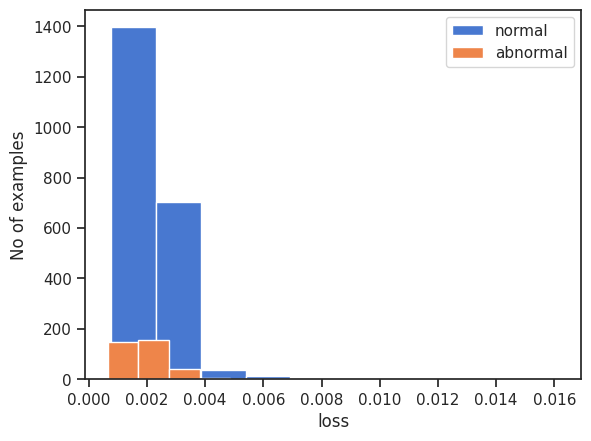

In [ ]:
plt.hist(train_loss, label='normal')
plt.hist(val_loss, label='abnormal')
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


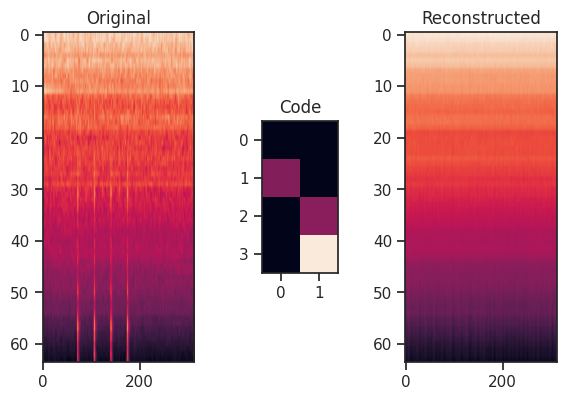

In [ ]:
visualize(train[0], autoencoder.encoder, autoencoder.decoder)

1/1 [==============================] - 0s 9ms/step


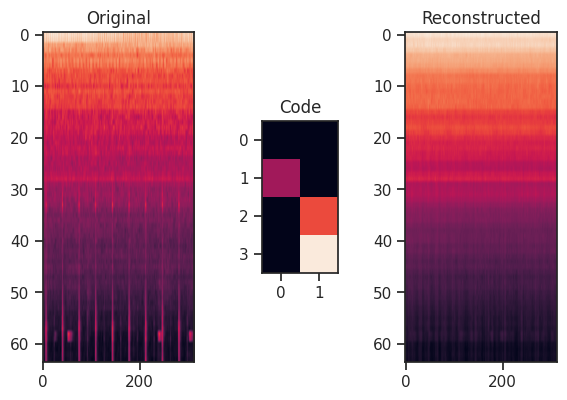

In [ ]:
visualize(val_abnorm[0], autoencoder.encoder, autoencoder.decoder)

## Fan

In [ ]:
train, val_data, val_norm, val_abnorm = get_matrices(df_fan, feat='mel')

  0%|          | 0/2448 [00:00<?, ?it/s]

  0%|          | 0/4174 [00:00<?, ?it/s]

  0%|          | 0/3060 [00:00<?, ?it/s]

  0%|          | 0/1114 [00:00<?, ?it/s]

In [ ]:
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

In [ ]:
inputDim = train.shape[1:]
print(inputDim)

(64, 313)


In [ ]:
autoencoder, fan_mel = train_and_eval(train, val_data, y_val, inputDim, device='fan', feat='mel')

Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.0412 - val_loss: 0.0027
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/50
28/40 [====================>.........] - ETA: 0s - loss: 0.0022

KeyboardInterrupt: 

In [ ]:
reconstructions = autoencoder.predict(train)
train_loss = get_mse(train, reconstructions)
reconstructions2 = autoencoder.predict(val_abnorm)
val_loss = get_mse(val_abnorm, reconstructions2)

35/35 [==============================] - 0s 1ms/step


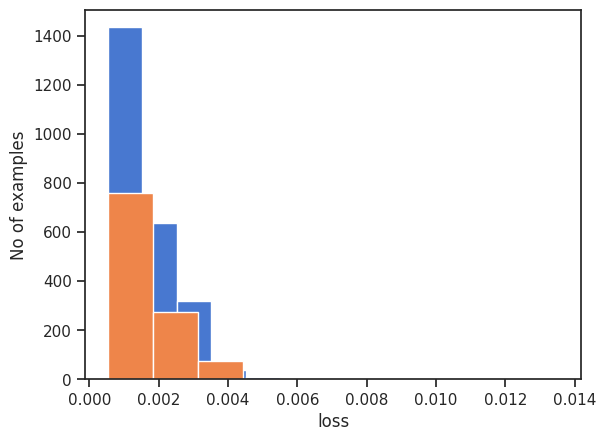

In [ ]:
plt.hist(train_loss, label='normal')
plt.hist(val_loss, label='abnormal')
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.show()

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


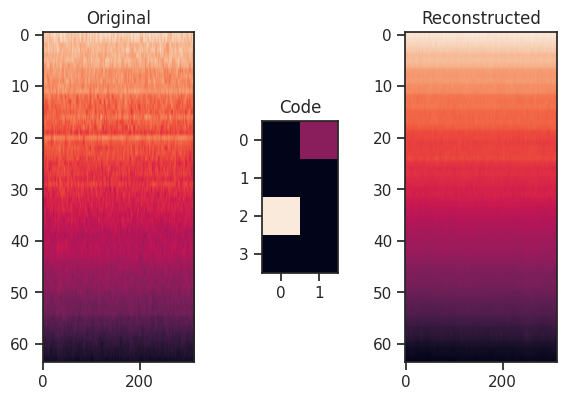

In [ ]:
visualize(train[0], autoencoder.encoder, autoencoder.decoder)

1/1 [==============================] - 0s 11ms/step


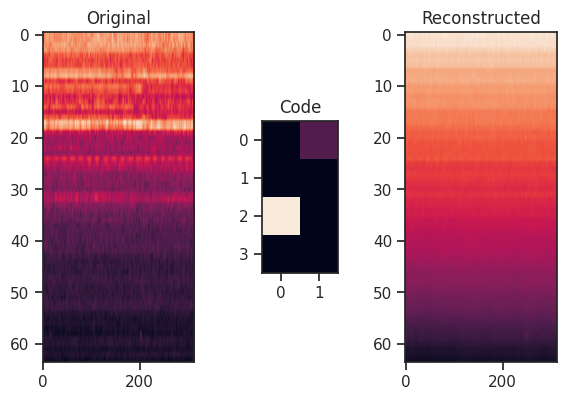

In [ ]:
visualize(val_abnorm[3], autoencoder.encoder, autoencoder.decoder)

# Chroma AE

## Valve

In [ ]:
train, val_data, val_norm, val_abnorm = get_matrices(df_valve, feat='chroma')

  0%|          | 0/2159 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

  0%|          | 0/2699 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

In [ ]:
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

In [ ]:
inputDim = train.shape[1:]
print(inputDim)

(12, 63)


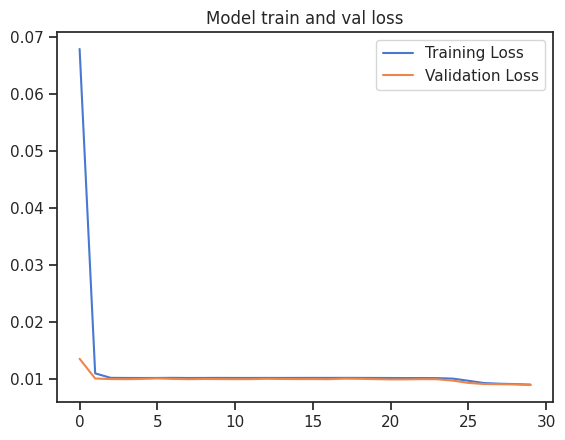

68/68 [==============================] - 0s 537us/step
Cutoff: 0.013974934816360474
 Prop. of Traning data over Threshold: 0.12413154238073182

|    | Model   | Machine   | Feat_Label   |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
|---:|:--------|:----------|:-------------|---------:|------------:|---------:|-------------------:|
|  0 | AE      | valve     | chroma       | 0.488265 |    0.879836 |  0.87625 |          0.0987654 |
Model saved to path: models/valve_chroma_AE.hdf5



In [ ]:
autoencoder, valve_chroma = train_and_eval(train, val_data, y_val, inputDim, device='valve', feat='chroma', epochs=30)

In [ ]:
reconstructions = autoencoder.predict(train)
train_loss = get_mse(train, reconstructions)
reconstructions2 = autoencoder.predict(val_abnorm)
val_loss = get_mse(val_abnorm, reconstructions2)

12/12 [==============================] - 0s 530us/step


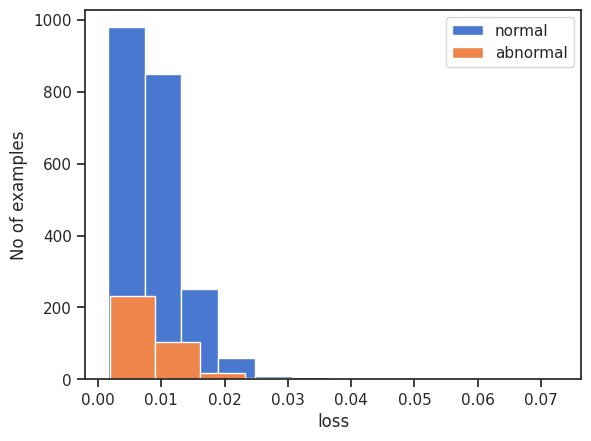

In [ ]:
plt.hist(train_loss, label='normal')
plt.hist(val_loss, label='abnormal')
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


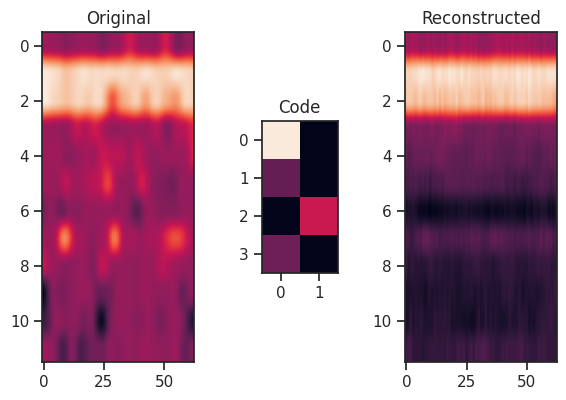

In [ ]:
visualize(train[0], autoencoder.encoder, autoencoder.decoder)

1/1 [==============================] - 0s 8ms/step


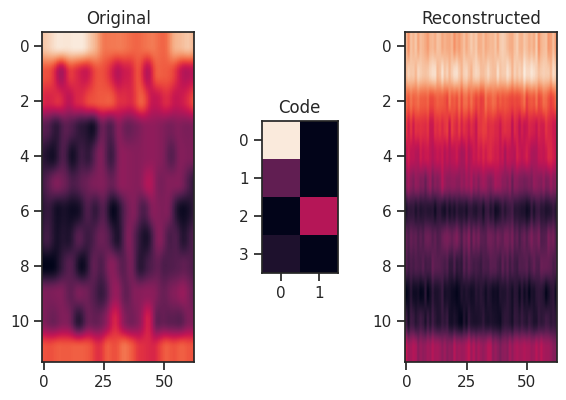

In [ ]:
visualize(val_abnorm[0], autoencoder.encoder, autoencoder.decoder)

## Fan

In [ ]:
train, val_data, val_norm, val_abnorm = get_matrices(df_fan, feat='chroma')

  0%|          | 0/2448 [00:00<?, ?it/s]

  0%|          | 0/4174 [00:00<?, ?it/s]

  0%|          | 0/3060 [00:00<?, ?it/s]

  0%|          | 0/1114 [00:00<?, ?it/s]

In [ ]:
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

In [ ]:
inputDim = train.shape[1:]
print(inputDim)

(12, 63)


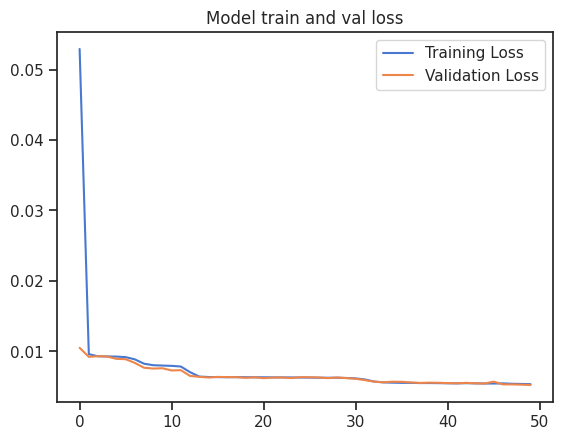

77/77 [==============================] - 0s 508us/step
Cutoff: 0.009194609709084034
 Prop. of Traning data over Threshold: 0.10743464052287582

|    | Model   | Machine   | Feat_Label   |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
|---:|:--------|:----------|:-------------|---------:|------------:|---------:|-------------------:|
|  0 | AE      | fan       | chroma       | 0.528213 |    0.745749 | 0.888562 |           0.227771 |
Model saved to path: models/fan_chroma_AE.hdf5



In [ ]:
autoencoder, fan_chroma = train_and_eval(train, val_data, y_val, inputDim, device='fan', feat='chroma')

In [ ]:
reconstructions = autoencoder.predict(train)
train_loss = get_mse(train, reconstructions)
reconstructions2 = autoencoder.predict(val_abnorm)
val_loss = get_mse(val_abnorm, reconstructions2)

35/35 [==============================] - 0s 426us/step


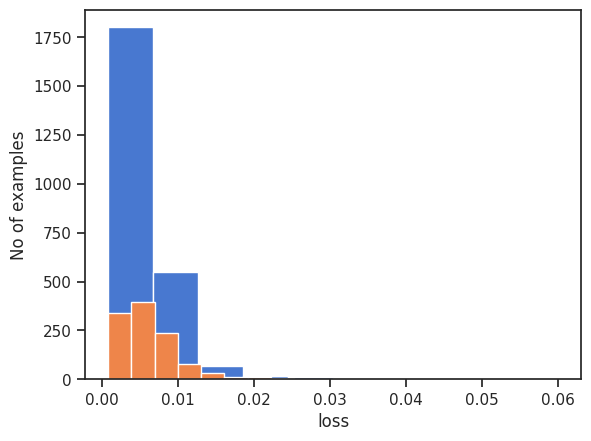

In [ ]:
plt.hist(train_loss, label='normal')
plt.hist(val_loss, label='abnormal')
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.show()

1/1 [==============================] - 0s 29ms/step


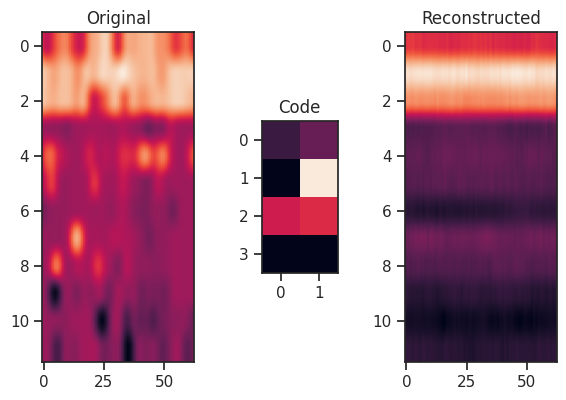

In [ ]:
visualize(train[0], autoencoder.encoder, autoencoder.decoder)

1/1 [==============================] - 0s 8ms/step


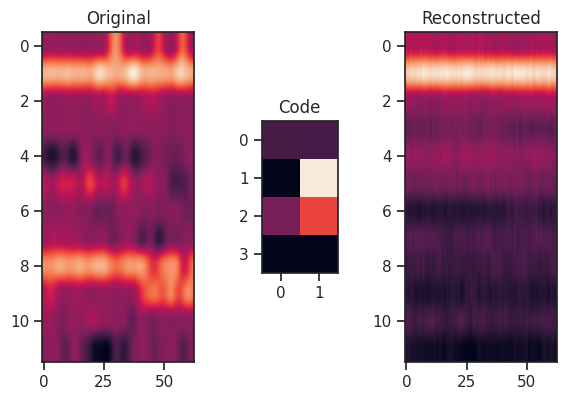

In [ ]:
visualize(val_abnorm[3], autoencoder.encoder, autoencoder.decoder)

# Compile eval Results

In [ ]:
Fan_res = pd.concat([fan_mel, fan_chroma], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
valve_res = pd.concat([valve_mel, valve_chroma], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
Fan_res.rename(columns={'Feat_Label':'Features'}).to_pickle('working/AE_fan_res.pkl')
valve_res.rename(columns={'Feat_Label':'Features'}).to_pickle('working/AE_valve_res.pkl')

In [ ]:
print('Valve machine sound classification - Feature combos')
print(valve_res.head().to_markdown())

Valve machine sound classification - Feature combos
|    | Model   | Machine   | Feat_Label   |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
|---:|:--------|:----------|:-------------|---------:|------------:|---------:|-------------------:|
|  0 | AE      | valve     | mel          | 0.511798 |    0.885275 | 0.917747 |          0.122779  |
|  1 | AE      | valve     | chroma       | 0.488265 |    0.879836 | 0.87625  |          0.0987654 |


In [ ]:
print('Fan machine sound classification - Feature combos')
print(Fan_res.head().to_markdown())

Fan machine sound classification - Feature combos
|    | Model   | Machine   | Feat_Label   |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
|---:|:--------|:----------|:-------------|---------:|------------:|---------:|-------------------:|
|  0 | AE      | fan       | mel          | 0.5197   |    0.742372 | 0.84281  |           0.241455 |
|  1 | AE      | fan       | chroma       | 0.528213 |    0.745749 | 0.888562 |           0.227771 |
